#### Reinvent4を使いRip kinase阻害剤様の構造を出すモデルを作成してみましょう。
- reinvent4はインストール済みの環境において以下のようにCLIで利用します。
- これまでのバージョンと異なりTOML形式のConfigファイルを読み込み可能です。
```bash
$ reinvent -l log.txt config.toml
```
- 今回は転移学習とSamplingを利用します。
- ../data/genai/ 以下にTomlファイルがあります。Priormodelやその他出力部分のPATHは各自のファイル格納先に応じて変更してから利用して下さい。
- 転移学習部分はGPUがないと時間がかかると思います。SMILESの数を適宜調整していただいて構いません。
- 転移学習のTOMLファイルを見てみましょう。
- Pathは絶対パスで指定すると任意の場所のファイルの読み込み、書き込みができますので適宜変更して下さい。

In [1]:
!cat ../data/genai/transfer_learning.toml

# REINVENT4 TOML input example for transfer learning
#
# Focus a given model towards a set of input SMILES.  This can also be used to
# start from scratch from and an untrained prior.


run_type = "transfer_learning"
device = "cuda:0"  # set torch device e.g. "cpu"
tb_logdir = "tb_TL"  # name of the TensorBoard logging directory
json_out_config = "json_transfer_learning.json"  # write this TOML to JSON


[parameters]

num_epochs = 3  # number of steps to run
save_every_n_epochs = 3  # save checkpoint model file very N steps
batch_size = 50
num_refs = 100  # number of reference molecules randomly chosen for similarity
                # set this to zero for large datasets (>200 molecules)!
sample_batch_size = 100  # number of sampled molecules to compute sample loss
# Uncomment one of the comment blocks below.  Each generator needs a model
# file and possibly a SMILES file with seed structures.

## Reinvent
input_model_file = "/home/iwatobipen/dev/REINVENT4/priors/reinvent.prior"
smiles_

- 上記のTomlファイルを利用し、転移学習を実施します。
- Notebook上から実施する場合、Subprocessを利用します。
- Callするreinventコマンドは各自のインストールパスに依存しますので適宜書き換えて下さい。

In [2]:
import subprocess

In [3]:
subprocess.call(
    ["/home/iwatobipen/miniforge3/envs/reinvent4/bin/reinvent", "-l", "TL.log", "../data/genai/transfer_learning.toml"]
)

|          |00:00
Epoch 3: |##########|00:01
0it [00:01, ?it/s]


0

In [31]:
!cat ../data/genai/sampling.toml

# REINVENT4 TOML input example for sampling
#


run_type = "sampling"
device = "cuda:0"  # set torch device e.g. "cpu"
json_out_config = "_sampling.json"  # write this TOML to JSON


[parameters]

# Uncomment one of the comment blocks below.  Each generator needs a model
# file and possibly a SMILES file with seed structures.

## Reinvent: de novo sampling
model_file = "/home/iwatobipen/dev/REINVENT4/priors/reinvent.prior"

## LibInvent: find R-groups for the given scaffolds
#model_file = "priors/libinvent.prior"
#smiles_file = "scaffolds.smi"  # 1 scaffold per line with attachment points

## LinkInvent: find a linker/scaffold to link two fragments
#model_file = "priors/linkinvent.prior"
#smiles_file = "warheads.smi"  # 2 warheads per line separated with '|'

## Mol2Mol: find molecules similar to the provided molecules
#model_file = "priors/mol2mol_medium_similarity.prior"
#smiles_file = "mol2mol.smi"  # 1 compound per line
#sample_strategy = "beamsearch"  # multinomial or beamsearch (

In [22]:
import subprocess
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools

In [19]:
df = pd.read_csv('../data/RIPK3_chembl.csv', sep=',')
print(df.shape)
df.tail(2)

(327, 4)


,id,name,smiles,note
325,327,CHEMBL4549667,CN1C(=O)[C@@H](N2CCc3c(nn(Cc4ccccc4)c3Br)C2=O)...,NaN
326,328,CHEMBL4097778,CN1C(=O)[C@@H](N2CCc3cn(CC4CCS(=O)(=O)CC4)nc3C...,NaN


In [23]:
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='smiles')

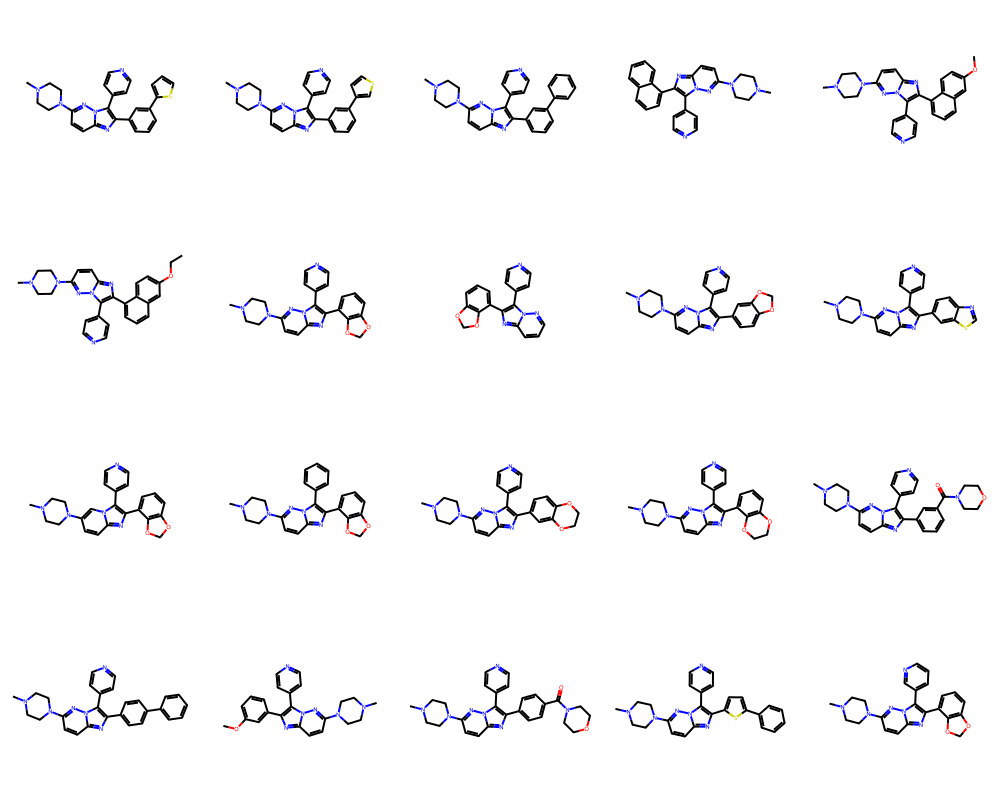

In [26]:
Draw.MolsToGridImage(df.ROMol[:20], molsPerRow=5)

In [28]:
with open('../data/genai/TL_reinvent_100.smi', 'w') as outf:
    for i, row in enumerate(df.smiles):
        outf.write(f'{row}\n')
        if i == 99:
            break